In [1]:
import gym
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.optim as optim

In [2]:
%matplotlib inline

In [3]:
env = gym.make('CartPole-v0').unwrapped
env.reset()

array([0.04855213, 0.04504854, 0.03977788, 0.02718396])

In [20]:
EPISODES = 800
THETA_LR = 0.01
GAMMA = 0.999
THETA_HIDDEN_LAYER1 = 16
THETA_HIDDEN_LAYER2 = 32
NUM_ACTIONS = env.action_space.n
NUM_OBS = len(env.reset())
EPISODE_DURATION = []
AVG_OVER_50 = []

In [21]:
class theta_network(nn.Module):
    def __init__(self):
        super(theta_network, self).__init__()
        self.fc0 = nn.Linear(NUM_OBS, THETA_HIDDEN_LAYER1)
        self.fc1 = nn.Linear(THETA_HIDDEN_LAYER1, THETA_HIDDEN_LAYER2)
        self.fc2 = nn.Linear(THETA_HIDDEN_LAYER2, NUM_ACTIONS)
    
    def forward(self, t):
        t = F.relu(self.fc0(t))
        t = F.relu(self.fc1(t))
        t = F.softmax(self.fc2(t),dim=1)
        return t

In [22]:
policy = theta_network()

In [23]:
theta_optim = optim.Adam(policy.parameters(), lr = THETA_LR)

In [24]:
def select_action(state):
    action_probs = policy(state).detach().numpy().reshape(NUM_ACTIONS)
    action = np.random.choice(np.arange(len(action_probs)), p = action_probs)
    return action

In [25]:
net_reward = 0
for episode in range(EPISODES):
    states = []
    actions = []
    rewards = []
    returns = []
    time_in_episode = 0
    curr_state = env.reset()
    while True:
        curr_action = select_action(torch.FloatTensor(curr_state).unsqueeze(0))
        next_state, rew, done, _ = env.step(curr_action)
        states.append(curr_state)
        actions.append(curr_action)
        rewards.append(rew)
        net_reward += rew
        curr_state = next_state
        time_in_episode += 1
        if done or time_in_episode > 10000:
            break
    EPISODE_DURATION.append(time_in_episode)
    prev_G = 0
    for t in range(time_in_episode):
        G = 0
        if t == 0:
            I = 1
            for r in rewards:
                G += r*I
                I *= GAMMA
        else:
            G = (prev_G - rewards[t-1])/GAMMA
        returns.append(G)
        prev_G = G
        
    return_mean = np.mean(returns)
    return_std = np.std(returns)
    
    for i in range(len(returns)):
        returns[i] = (returns[i] - return_mean)/return_std

    theta_optim.zero_grad()            
    for t in range(time_in_episode):    
        pi = policy(torch.FloatTensor(states[t]).unsqueeze(0))
        delta = returns[t]
        loss = - delta * torch.log(pi[0][actions[t]])
        loss.backward()
    theta_optim.step()
        
    #print(f'Time spent in episode {episode} is {time_in_episode}')
    #print('\n')    
    if not episode % 50:
        print(f'Average reward after episode {episode}: {net_reward/50}')
        AVG_OVER_50.append(net_reward/50)
        print('\n')
        net_reward = 0

Average reward after episode 0: 0.46


Average reward after episode 50: 32.74


Average reward after episode 100: 96.6


Average reward after episode 150: 231.9


Average reward after episode 200: 3652.46


Average reward after episode 250: 76.14


Average reward after episode 300: 345.78


Average reward after episode 350: 293.42


Average reward after episode 400: 7396.44


Average reward after episode 450: 7940.46


Average reward after episode 500: 8720.24


Average reward after episode 550: 10001.0


Average reward after episode 600: 10001.0


Average reward after episode 650: 6406.42


Average reward after episode 700: 11.98


Average reward after episode 750: 12.86




In [26]:
def plot_duration():
    plt.figure(figsize = (10,15))
    plt.xlabel('EPISODE')
    plt.ylabel('DURATION')
    plt.plot(EPISODE_DURATION)
    plt.grid()
    plt.show()

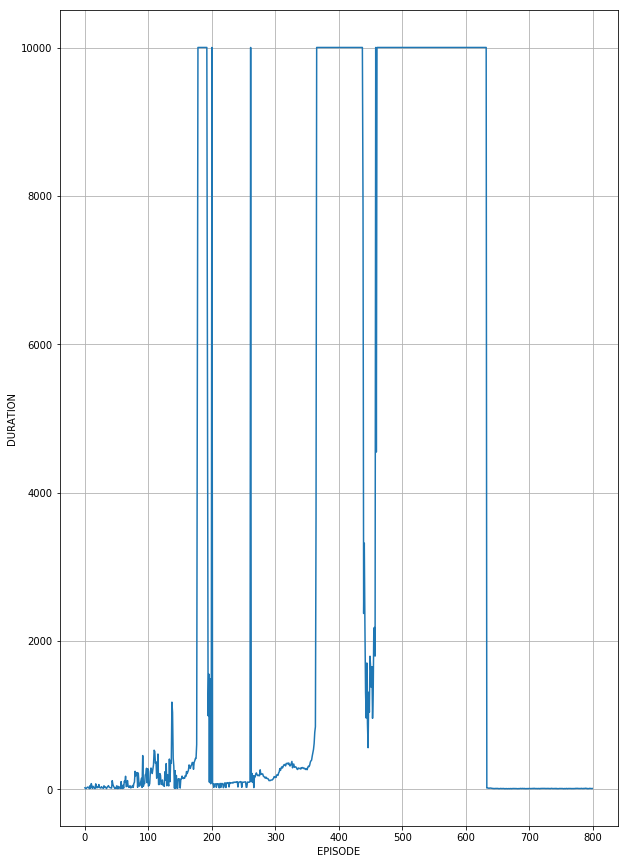

In [27]:
plot_duration()

In [32]:
def plot_rewards():
    plt.figure(figsize = (10,15))
    plt.xlabel('EVERY 50 EPISODES')
    plt.ylabel('AVERAGE REWARD OVER 50 EPISODES')
    plt.plot(AVG_OVER_50)
    plt.grid()
    plt.show()

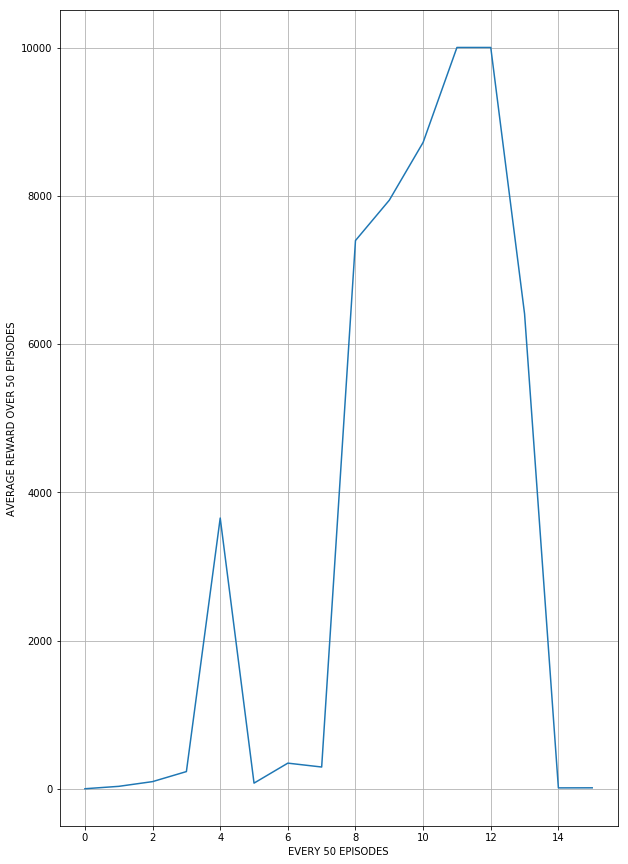

In [33]:
plot_rewards()